In [25]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import matplotlib.pyplot as plt
import pandas.plotting
import pandas as pd
import numpy as np

# 回归预测加州房价
本文是一个机器学习回归问题的完整案例，参考《Hands-On Machine Learning with Scikit-Learn and TensorFlow》。

## 1. 机器学习基本流程
一个机器学习项目的基本开发流程如下：
- 定义主要的应用场景
- 获取数据
- 通过分析和可视化等手段初步分析数据
- 清洗、整理数据
- 选择一个机器学习算法，输入数据训练模型
- 调整参数，优化模型性能
- 将优化好的模型部署到线上系统
- 运行、监控和维护你的系统

本文将使用StatLib提供的加州房价历史数据训练模型、预测房价。

## 2. 场景分析
我们使用的数据集是1990年左右加州的房价数据，虽然已经很旧了，但是这份数据质量很好，是很好的学习资料。数据体现出的基本信息如下图所示：
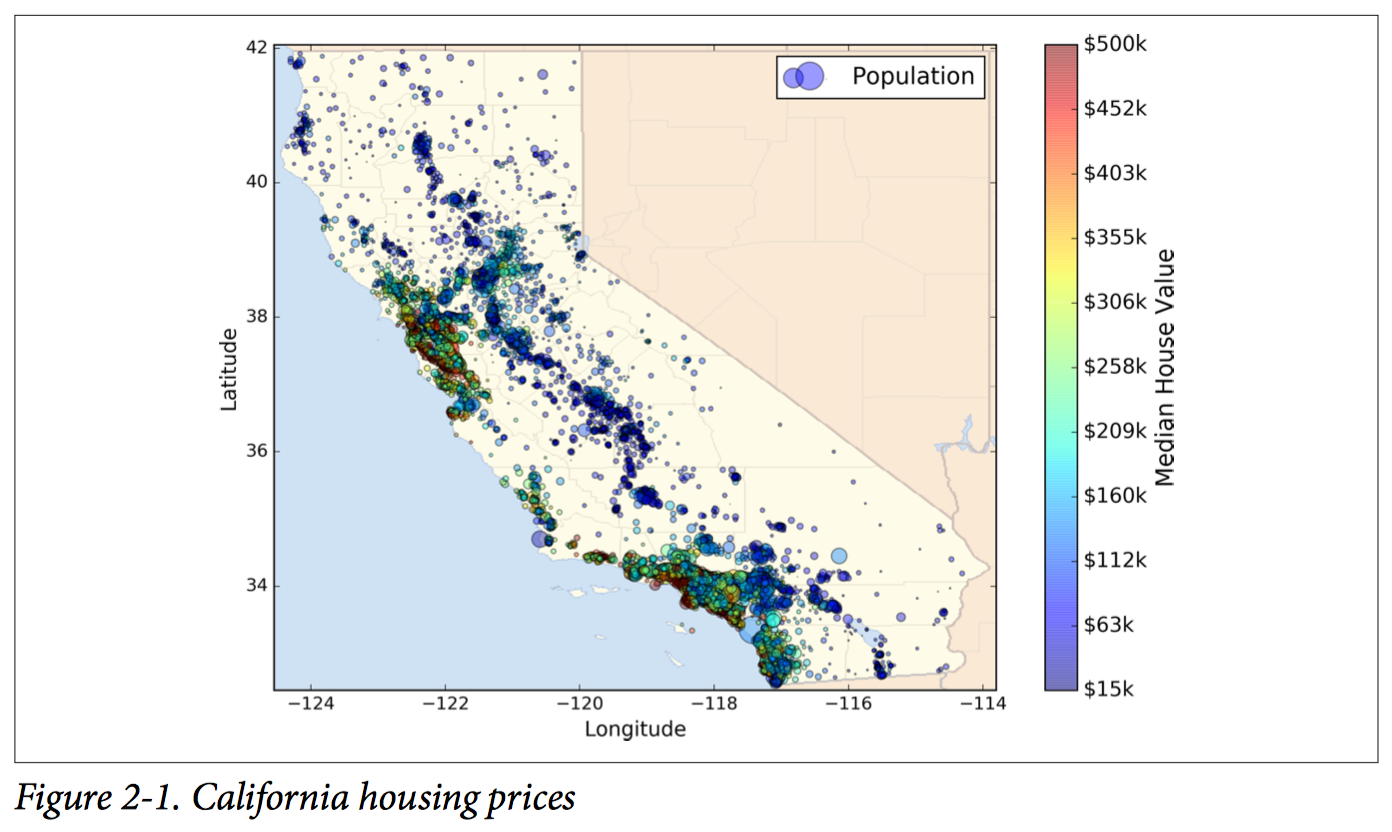

这份数据以小区为单位(US人口普查将城市小区划分，每个小区大约600到3000人)，提供了每个小区的人口数、平均收入、平均房价等信息。我们使用这份数据训练模型并预测房价。

### 2.1 定义问题
我们需要明确房价预测是监督学习还是无监督学习、分类问题还是回归问题、批量学习还是在线学习等等。

很明显，我们的问题是一个监督学习问题。模型需要预测具体的房价，因此这是个回归问题。另外，数据不会实时提供给模型，因此这是个批量学习问题。

### 2.2 选择性能评估方法
我们可以使用RMSE、MAE等方法评估性能。一般来讲，各种机器学习的库提供了各种评估方法，又叫作`损失函数`。

### 2.3 评估输出结果
评估模型的最终输出结果是否满足最终的应用场景。比如我们的模型输出只是一个生产系统的一部分，模型的输出将作为下游系统的输入，因此，我们需要检查我们的输出类型、范围等是否满足需要。

## 3. 获取数据
数据可以从公开数据集下载，或者使用爬虫。本文中我们从github下载数据并上传到服务器上。

### 3.1 浏览数据
加载数据集，初略浏览一下：

In [2]:
housing = pd.read_csv("data/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


数据的每一行代表一个小区的记录，每条记录有10个特征：经度、纬度、平均房龄、房间数、卧室数、居民数、家庭数、平均收入、平均房价、是否紧邻海岸。

我们再看下每个特征的信息：

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


数据集中一共有20640条记录，从机器学习的角度看，这个数据集非常小，但是可以作为一个很好的学习材料。之后我们关注特征值是否有缺失，从上面的统计看，total_bedrooms只有20433条非null值，后续我们需要处理这些null值。

大部分的特征都是数值类型，除了ocean_proximity。ocean_proximity是字符串类型，从info()的输出我们判断它的值可能是有限的分类信息，我们通过value_counts()来统计一下分类的数量:

In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

对数据有了大致了解之后，我们再看一下每个特征的统计信息：

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


图形可以更好的反映数据的分布情况：

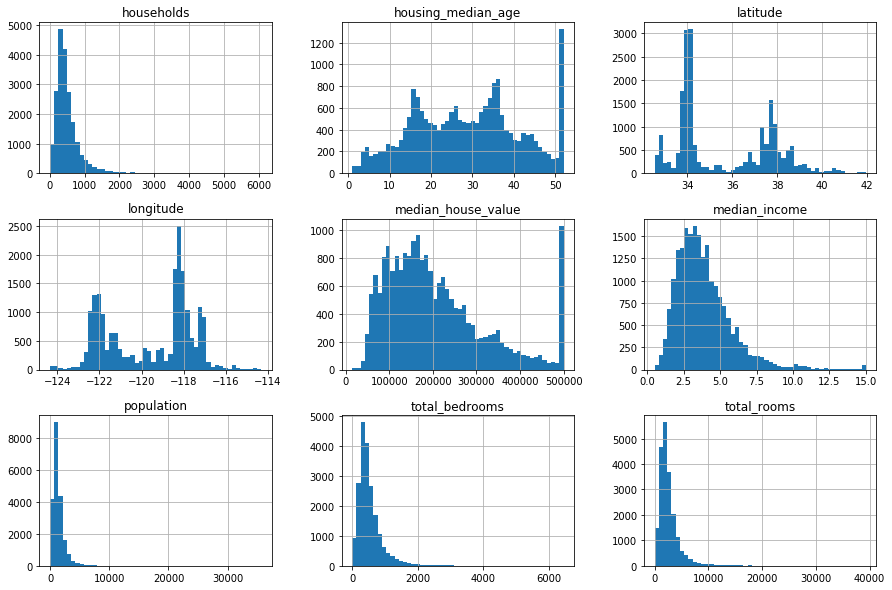

In [6]:
housing.hist(bins=50, figsize=(15,10))
plt.show()

从直方图中可以看到:
1. 平均收入`median income`的值已经被处理过了，收入范围被限制在0.5和15.000之间

2. 平均房龄和平均房价也被限制在了一个范围内。平均房价可能是个问题，因为这个值是模型将要预测的值，训练处理的模型预测的房价不可能超过限制范围的最大值(这里是50万)。这个问题需要和使用你的模型的用户沟通，结果可能是他们需要超过50万的房子的信息，那么有两个处理方法:
    - 收集被处理前的数据
    - 从训练集和测试集中移除50万的数据

3. 每个特征的值的范围都有很大的不同，这个可能会影响模型的性能

4. 很多直方图都有长尾现象。一些模型很难处理长尾现象，我们需要通过变换使数据复合`钟型分布`

### 3.2 分离测试集
从数据集中分离出20%用于测试模型的性能(注意：原文假设收入的等级对房价影响很重要，因此把平均收入进行分级，之后重新分离测试集，本文中没有使用这种方法)：

In [7]:
train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)

## 4. 分析数据
对数据有了初步的认识之后，我们通过可视化等手段挖掘数据的内在规律。在数据分析的过程中，我们只使用训练集。为了不污染数据，我们使用训练集的一个拷贝：

In [8]:
housing = train_set.copy()

### 4.1 可视化数据
因为数据包含地理信息，我们可以通过显示地图分析数据：

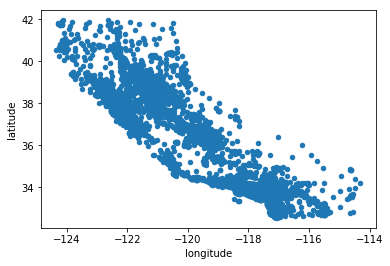

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

这个图大致显示了加州的地形。我们设置alpha值来突出显示高房价的地区：

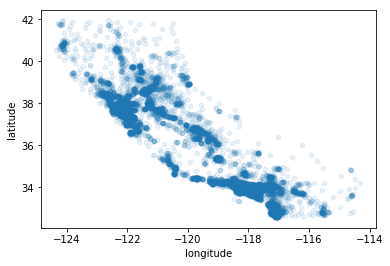

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

我们按房价和人口数量重绘地图，点的大小表示人口数量、点的颜色深浅表示房价高低：

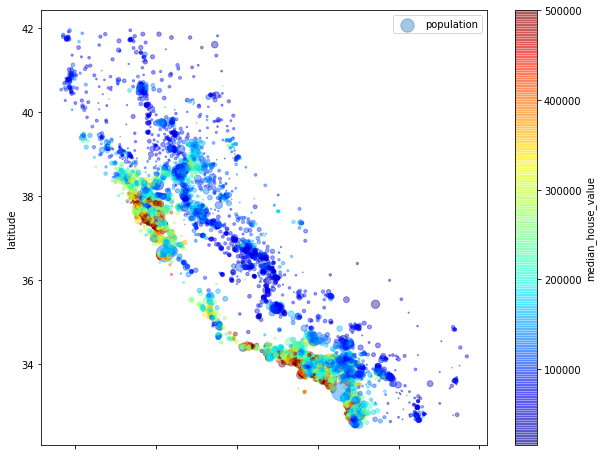

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             figsize=(10,8), label="population", 
             s=housing["population"]/100, c="median_house_value", 
             cmap=plt.get_cmap("jet"), colorbar=True, ) 
plt.legend()
plt.show()

这张图告诉我们，房价和地理位置、人口数量有很大关系(It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule)。

### 4.2 相关度
我们使用的数据集不是很大，我们可以计算各个特征之间的皮尔逊相关度系数：

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

大于0的时候表示两者正相关，越接近1相关度越大；小于0的时候表示两者负相关，越接近-1表示负相关度越大。

另外一种检查相关度的方法是使用Pandas库的scatter_matrix()。scatter_matrix()显示特征两两之间的相关度，我们只挑选几个对房价影响显著的特征：

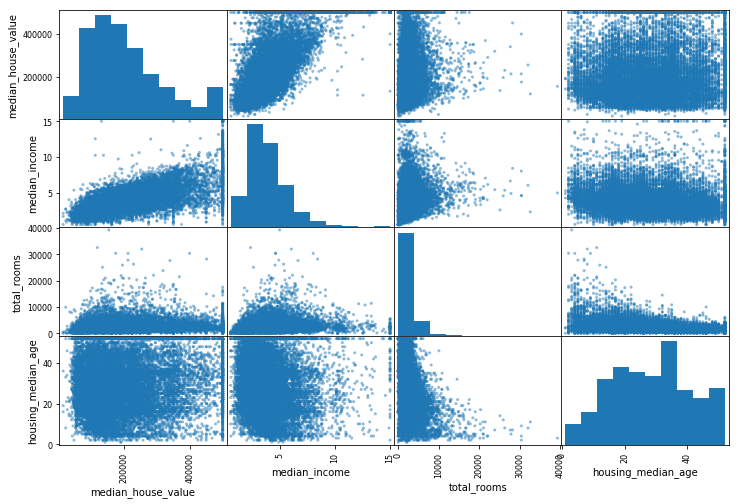

In [13]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] 
pandas.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

和房价相关度最高的是平均收入，我们提取这两个特征再做进一步分析：

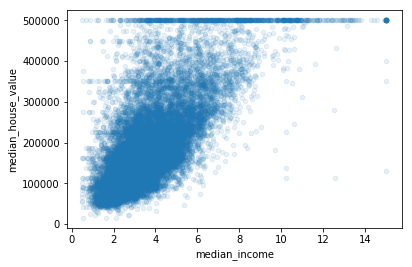

In [14]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### 4.3 特征合并
根据常识，如果不考虑居住的人数的话，房间的数量对预测实际并没有太多的贡献，我们关心的是每个家庭拥有的房间数、卧室的占比、以及每个家庭的人口数量。因此我们何必一些特征，生成新的特征：

In [15]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

相关性系数证实了我们的猜想：The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower `bedroom/room ratio` tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are。

注意：实际应用中这个过程应该是交互式的，即先训练一个模型测试性能，之后修改数据，再进行一轮测试验证效果。

## 5. 准备数据
我们应当让这个过程自动化，这样可以反复多次的使用数据进行测试、验证不同的算法。

首先分离标签，准备一份新的数据拷贝：

In [27]:
housing = train_set.drop("median_house_value", axis=1) 
housing_labels = train_set["median_house_value"].copy()

housing_test = test_set.drop("median_house_value", axis=1) 
housing_test_labels = test_set["median_house_value"].copy()

### 5.1 数据清洗
之前已经提到，特征`total_bedrooms`包含了null值，我们使用平均值填充：

In [17]:
imputer = sklearn.preprocessing.Imputer(strategy="median")

# 首先删除非数值类型的特征
housing_num = housing.drop("ocean_proximity", axis=1)
# 计算平均值
imputer.fit(housing_num)
# 填充缺失的特征值，返回一个numpy数组
X = imputer.transform(housing_num)
# 将numpy数组转换为Pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### 5.2 处理文本值
首先将文本值转换给数值类型，之后采用one-hot编码：

In [18]:
encoder = sklearn.preprocessing.LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
housing_cat_1hot

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 5.3 特征值标准化
很多算法对于特征值的范围非常敏感，我们采用scikit-learn的StandardScaler类将数值标准化。

### 5.4 合成一个数据处理管道
我们将上面的特征合并、缺失值填充、文本值处理、标准化等封装在一个管道里：

In [24]:
# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(sklearn.base.TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = sklearn.preprocessing.LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', sklearn.preprocessing.Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', sklearn.preprocessing.StandardScaler()),
    ])

cat_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

full_pipeline = sklearn.pipeline.FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

## 6. 训练模型
我们先选择一个线性模型测试一下：

In [26]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67593.207457752535

大多数的房价在\$120,000和\$265,000之间，因此，67593并不算太好。我们训练一个决策树模型再测试一下：